## FOOD INSPECTIONS ANALYSIS IMPLEMENTING TOKENIZATION

Author: Shweta Sampath Kumar<br>
Class: MSCA 32018 IP01 Natural Language Processing and Cognitive Computing<br>
Assignment: 2<br>
Date: 4/3/2022

In [1]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import seaborn as sns
import locale

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import ipywidgets as widgets
from IPython.display import display_html
import time

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### 1. Similar to Assignment 1, filter the data for failed inspections and only keep records where Violations description is not blank.

In [2]:
df = pd.read_csv('Food_Inspections.csv')    # Read the dataset downloaded from https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5
violations = df[df['Results'] == 'Fail']    # Select only the records corresponding to failed inspection
violations = violations.dropna(subset=['Violations'])   # Cleaning the data by removing null values under Violations column

#### 2. Using regex, separate the violation description and comments into separate data frame columns.

In [3]:
violations['Reasons'] = violations['Violations'].apply(lambda x: re.split('\|\s', x))   # splitting the Violations by '|' and space 
violations['Key'] = violations['License #'].astype(str) + '-' + violations['DBA Name'] + '-' + violations['Address'].astype(str) #Making a key of License #, DBA Name and Address to identify a unique business

reasons = violations[['Inspection ID', 'DBA Name', 'License #', 'Address', 'Key', 'Reasons', 'Inspection Date']].explode('Reasons') #Exploding the list of violations to a separate row
reasons = pd.DataFrame(reasons)
reasons['Code'] = reasons['Reasons'].apply(lambda x: re.findall(r'^[\d]+', x))
reasons['Code'] = reasons['Code'].apply(lambda x: ''.join(map(str, x))).astype(int)

reasons['Comments'] = reasons['Reasons'].apply(lambda x: re.findall(r'\d+\.\s*.*\s*-\s*Comments\:\s*(.*)', x, re.IGNORECASE))
reasons['Reasons_modified'] = reasons['Reasons'].apply(lambda x: re.findall(r'\d+\.\s*(.*?)(?=\s*(?:-*\s*Comments*))', x, re.IGNORECASE) if (re.findall(r'(Comments)', x, re.IGNORECASE)) else re.findall(r'\d+\.\s*(.*)$', x, re.IGNORECASE))

reasons['Reasons_modified'] = reasons['Reasons_modified'].apply(lambda x: x[0].rstrip())    # rstrip() to remove spaces at the end
reasons['Key'] = reasons['Key'].apply(lambda x: x.rstrip()) # rstrip() to remove spaces at the end
reasons['Key'] = reasons['Key'].apply(lambda x: x.upper())  # Change key to uppercase to ensure that case is ignored in the Key
reasons['Comments'] = reasons['Comments'].apply(lambda x: str(np.nan) if x == [] else x[0].rstrip())

reasons[['Reasons', 'Code', 'Reasons_modified', 'Comments']].head()

,Reasons,Code,Reasons_modified,Comments
36,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",3,"MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPL...",2-102.14(O) OBSERVED NO EMPLOYEE HEALTH POLICY...
36,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,5,PROCEDURES FOR RESPONDING TO VOMITING AND DIAR...,2-501.11 OBSERVED NO WRITTEN PROCEDURE NOR ADE...
36,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,10,ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...,6-301.14 OBSERVED HAND WASHING SIGNS ARE NEEDE...
36,21. PROPER HOT HOLDING TEMPERATURES - Comments...,21,PROPER HOT HOLDING TEMPERATURES,3-501.16(A:1) OBSERVED TIME/TEMPERATURE CONTRO...
36,33. PROPER COOLING METHODS USED; ADEQUATE EQUI...,33,PROPER COOLING METHODS USED; ADEQUATE EQUIPMEN...,4-301.11 OBSERVED A HOT HOLDING UNIT (WITH TCS...


#### 3. Tokenize violation description and comment columns

In [4]:
reasons['Tokens_description'] = reasons['Reasons_modified'].apply(lambda x: nltk.tokenize.word_tokenize(x))
reasons['Tokens_comments'] = reasons['Comments'].apply(lambda x: nltk.tokenize.word_tokenize(x))
reasons[['Reasons_modified', 'Tokens_description', 'Comments', 'Tokens_comments']].head()

,Reasons_modified,Tokens_description,Comments,Tokens_comments
36,"MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPL...","[MANAGEMENT, ,, FOOD, EMPLOYEE, AND, CONDITION...",2-102.14(O) OBSERVED NO EMPLOYEE HEALTH POLICY...,"[2-102.14, (, O, ), OBSERVED, NO, EMPLOYEE, HE..."
36,PROCEDURES FOR RESPONDING TO VOMITING AND DIAR...,"[PROCEDURES, FOR, RESPONDING, TO, VOMITING, AN...",2-501.11 OBSERVED NO WRITTEN PROCEDURE NOR ADE...,"[2-501.11, OBSERVED, NO, WRITTEN, PROCEDURE, N..."
36,ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...,"[ADEQUATE, HANDWASHING, SINKS, PROPERLY, SUPPL...",6-301.14 OBSERVED HAND WASHING SIGNS ARE NEEDE...,"[6-301.14, OBSERVED, HAND, WASHING, SIGNS, ARE..."
36,PROPER HOT HOLDING TEMPERATURES,"[PROPER, HOT, HOLDING, TEMPERATURES]",3-501.16(A:1) OBSERVED TIME/TEMPERATURE CONTRO...,"[3-501.16, (, A:1, ), OBSERVED, TIME/TEMPERATU..."
36,PROPER COOLING METHODS USED; ADEQUATE EQUIPMEN...,"[PROPER, COOLING, METHODS, USED, ;, ADEQUATE, ...",4-301.11 OBSERVED A HOT HOLDING UNIT (WITH TCS...,"[4-301.11, OBSERVED, A, HOT, HOLDING, UNIT, (,..."


#### 4. Find top-10 tokens of each column

In [5]:
r_desc = reasons['Tokens_description'].explode()
r_desc_f1 = pd.DataFrame(r_desc.value_counts()).reset_index().rename({'index':'Token_Uncleaned', 'Tokens_description':'Count of Tokens Uncleaned'}, axis=1)

r_comments = reasons['Tokens_comments'].explode()
r_comments_f1 = pd.DataFrame(r_comments.value_counts()).reset_index().rename({'index':'Token_Uncleaned', 'Tokens_comments':'Count of Tokens Uncleaned'}, axis=1)

In [6]:
print("TOP 10 TOKENS FOR DESCRIPTION")
r_desc_f1.head(10).style.hide(axis='index').format({'Count of Tokens Uncleaned': '{:,.0f}'})

TOP 10 TOKENS FOR DESCRIPTION


Token_Uncleaned,Count of Tokens Uncleaned
",","357,589"
AND,"169,521"
:,"126,080"
MAINTAINED,"84,923"
FOOD,"84,210"
PROPERLY,"68,545"
CLEAN,"66,920"
&,"66,745"
CONSTRUCTED,"66,183"
EQUIPMENT,"64,410"


In [7]:
print("TOP 10 TOKENS FOR COMMENTS")
r_comments_f1.head(10).style.hide(axis='index').format({'Count of Tokens Uncleaned': '{:,.0f}'})

TOP 10 TOKENS FOR COMMENTS


Token_Uncleaned,Count of Tokens Uncleaned
.,"683,000"
AND,"347,893"
",","340,340"
THE,"255,757"
IN,"232,456"
TO,"219,466"
OF,"148,369"
MUST,"142,590"
ON,"130,234"
AT,"120,965"


#### 5. Clean each column: convert to lower case, remove stopwords, punctuation, numbers, etc

For description

In [8]:
r_desc = [x.lower() for x in r_desc] # Convert to lower case

stopwords = set(nltk.corpus.stopwords.words('english'))

r_desc = [word for word in r_desc if len(word) > 1] # Remove punctuation
r_desc = [word for word in r_desc if not word.isnumeric()] # Remove numbers
r_desc = [word for word in r_desc if word.isalpha()] # Remove punctuation
r_desc = [word for word in r_desc if word not in stopwords] # Remove stopwords

For comments

In [9]:
r_comments = [x.lower() for x in r_comments] # Convert to lower case

r_comments = [word for word in r_comments if len(word) > 1] # Remove punctuation
r_comments = [word for word in r_comments if not word.isnumeric()]
r_comments = [word for word in r_comments if word.isalpha()]
r_comments = [word for word in r_comments if word not in stopwords]

#### 6. Find top-10 tokens again

In [10]:
r_desc_df = pd.DataFrame(pd.DataFrame(r_desc).value_counts())
r_desc_df = r_desc_df.rename({r_desc_df.columns[0]:'Count of Tokens Cleaned'}, axis=1).reset_index().rename({0:'Tokens_Cleaned'}, axis=1)
print("TOP 10 TOKENS FOR DESCRIPTION AFTER CLEANING")
r_desc_df.head(10).style.hide(axis='index').format({'Count of Tokens Cleaned': '{:,.0f}'})

TOP 10 TOKENS FOR DESCRIPTION AFTER CLEANING


Tokens_Cleaned,Count of Tokens Cleaned
maintained,"84,923"
food,"84,210"
properly,"68,545"
clean,"66,920"
constructed,"66,183"
equipment,"64,410"
installed,"64,370"
cleaning,"48,295"
surfaces,"48,204"
contact,"45,212"


In [11]:
r_comments_df = pd.DataFrame(pd.DataFrame(r_comments).value_counts())
r_comments_df = r_comments_df.rename({r_comments_df.columns[0]:'Count of Tokens Cleaned'}, axis=1).reset_index().rename({0:'Tokens_Cleaned'}, axis=1)
print("TOP 10 TOKENS FOR COMMENTS AFTER CLEANING")
r_comments_df.head(10).style.hide(axis='index').format({'Count of Tokens Cleaned': '{:,.0f}'})

TOP 10 TOKENS FOR COMMENTS AFTER CLEANING


Tokens_Cleaned,Count of Tokens Cleaned
must,"152,065"
food,"125,855"
instructed,"124,042"
observed,"112,296"
clean,"108,918"
area,"99,109"
maintain,"82,212"
prep,"79,553"
sink,"79,491"
provide,"70,635"


#### 7. Find top-10 tokens after applying Porter stemming to the columns obtained in step 5.

For description

In [12]:
porter = nltk.PorterStemmer()
r_desc_portor = [porter.stem(x) for x in r_desc]
r_desc_portor = pd.DataFrame(pd.DataFrame(r_desc_portor).value_counts())
r_desc_portor = r_desc_portor.rename({r_desc_portor.columns[0]:'Count of Tokens Porter'}, axis=1).reset_index().rename({0:'Tokens_Porter'}, axis=1)
print("TOP 10 TOKENS FOR DESCRIPTION AFTER APPLYING PORTER")
r_desc_portor.head(10).style.hide(axis='index').format({'Count of Tokens Porter': '{:,.0f}'})

TOP 10 TOKENS FOR DESCRIPTION AFTER APPLYING PORTER


Tokens_Porter,Count of Tokens Porter
clean,"141,214"
food,"89,466"
maintain,"88,472"
properli,"68,545"
construct,"66,183"
equip,"64,410"
instal,"64,370"
surfac,"48,204"
contact,"45,212"
method,"41,000"


For Comments

In [13]:
r_comments_portor = [porter.stem(x) for x in r_comments]
r_comments_portor = pd.DataFrame(pd.DataFrame(r_comments_portor).value_counts())
r_comments_portor = r_comments_portor.rename({r_comments_portor.columns[0]:'Count of Tokens Porter'}, axis=1).reset_index().rename({0:'Tokens_Porter'}, axis=1)
print("TOP 10 TOKENS FOR COMMENTS AFTER APPLYING PORTER")
r_comments_portor.head(10).style.hide(axis='index').format({'Count of Tokens Porter': '{:,.0f}'})

TOP 10 TOKENS FOR COMMENTS AFTER APPLYING PORTER


Tokens_Porter,Count of Tokens Porter
must,"152,070"
food,"149,559"
area,"136,088"
clean,"135,449"
instruct,"124,223"
observ,"112,738"
sink,"94,874"
maintain,"92,657"
floor,"88,621"
provid,"82,354"


#### 8. Find top-10 tokens after applying Lancaster stemming to the columns obtained in step 5.

For description

In [14]:
lancaster = nltk.LancasterStemmer()
r_desc_lancaster = [lancaster.stem(x) for x in r_desc]
r_desc_lancaster = pd.DataFrame(pd.DataFrame(r_desc_lancaster).value_counts())
r_desc_lancaster = r_desc_lancaster.rename({r_desc_lancaster.columns[0]:'Count of Tokens Lancaster'}, axis=1).reset_index().rename({0:'Tokens_Lancaster'}, axis=1)
print("TOP 10 TOKENS FOR DESCRIPTION AFTER APPLYING LANCASTER")
r_desc_lancaster.head(10).style.hide(axis='index').format({'Count of Tokens Lancaster': '{:,.0f}'})

TOP 10 TOKENS FOR DESCRIPTION AFTER APPLYING LANCASTER


Tokens_Lancaster,Count of Tokens Lancaster
cle,"149,018"
food,"89,466"
maintain,"88,472"
prop,"84,837"
construct,"66,183"
equip,"64,410"
instal,"64,370"
surfac,"48,204"
contact,"45,212"
method,"41,000"


For Comments

In [15]:
r_comments_lancaster = [lancaster.stem(x) for x in r_comments]
r_comments_lancaster = pd.DataFrame(pd.DataFrame(r_comments_lancaster).value_counts())
r_comments_lancaster = r_comments_lancaster.rename({r_comments_lancaster.columns[0]:'Count of Tokens Lancaster'}, axis=1).reset_index().rename({0:'Tokens_Lancaster'}, axis=1)
print("TOP 10 TOKENS FOR COMMENTS AFTER APPLYING LANCASTER")
r_comments_lancaster.head(10).style.hide(axis='index').format({'Count of Tokens Lancaster': '{:,.0f}'})

TOP 10 TOKENS FOR COMMENTS AFTER APPLYING LANCASTER


Tokens_Lancaster,Count of Tokens Lancaster
must,"152,072"
food,"149,560"
cle,"147,493"
instruct,"124,252"
observ,"112,737"
are,"99,109"
prep,"96,862"
sink,"94,876"
stor,"93,797"
maintain,"92,671"


#### 9. Find top-10 tokens after applying lemmatization to the columns obtained in step 5.

For description

In [16]:
lemmatizer = nltk.WordNetLemmatizer()
r_desc_lemmatizer = [lemmatizer.lemmatize(x) for x in r_desc]
r_desc_lemmatizer = pd.DataFrame(pd.DataFrame(r_desc_lemmatizer).value_counts())
r_desc_lemmatizer = r_desc_lemmatizer.rename({r_desc_lemmatizer.columns[0]:'Count of Tokens Lemmatizer'}, axis=1).reset_index().rename({0:'Tokens_Lemmatizer'}, axis=1)
print("TOP 10 TOKENS FOR DESCRIPTION AFTER APPLYING LEMMATIZATION")
r_desc_lemmatizer.head(10).style.hide(axis='index').format({'Count of Tokens Lemmatizer': '{:,.0f}'})

TOP 10 TOKENS FOR DESCRIPTION AFTER APPLYING LEMMATIZATION


Tokens_Lemmatizer,Count of Tokens Lemmatizer
food,"89,466"
maintained,"84,923"
properly,"68,545"
clean,"66,920"
constructed,"66,183"
equipment,"64,410"
installed,"64,370"
cleaning,"48,295"
surface,"48,204"
contact,"45,212"


For Comments

In [17]:
r_comments_lemmatizer = [lemmatizer.lemmatize(x) for x in r_comments]
r_comments_lemmatizer = pd.DataFrame(pd.DataFrame(r_comments_lemmatizer).value_counts())
r_comments_lemmatizer = r_comments_lemmatizer.rename({r_comments_lemmatizer.columns[0]:'Count of Tokens Lemmatizer'}, axis=1).reset_index().rename({0:'Tokens_Lemmatizer'}, axis=1)
print("TOP 10 TOKENS FOR COMMENTS AFTER APPLYING LEMMATIZATION")
r_comments_lemmatizer.head(10).style.hide(axis='index').format({'Count of Tokens Lemmatizer': '{:,.0f}'})

TOP 10 TOKENS FOR COMMENTS AFTER APPLYING LEMMATIZATION


Tokens_Lemmatizer,Count of Tokens Lemmatizer
must,"152,069"
food,"149,558"
area,"136,089"
instructed,"124,042"
observed,"112,296"
clean,"108,923"
sink,"94,873"
floor,"88,269"
maintain,"82,212"
prep,"79,565"


#### 10. Compare top-10 tokens obtained in 4, 6, 7, 8, 9.

For description

In [18]:
r_desc_f1.merge(r_desc_df, left_index=True, right_index=True).merge(
    r_desc_portor, left_index=True, right_index=True).merge(
    r_desc_lancaster, left_index=True, right_index=True).merge(
    r_desc_lemmatizer, left_index=True, right_index=True).head(10).style.hide(axis='index').format({
    'Count of Tokens Lemmatizer': '{:,.0f}',
    'Count of Tokens Uncleaned': '{:,.0f}', 
    'Count of Tokens Cleaned': '{:,.0f}', 
    'Count of Tokens Porter': '{:,.0f}', 
    'Count of Tokens Lancaster': '{:,.0f}', 
    'Count of Tokens Lemmatizer': '{:,.0f}', })

Token_Uncleaned,Count of Tokens Uncleaned,Tokens_Cleaned,Count of Tokens Cleaned,Tokens_Porter,Count of Tokens Porter,Tokens_Lancaster,Count of Tokens Lancaster,Tokens_Lemmatizer,Count of Tokens Lemmatizer
",","357,589",maintained,"84,923",clean,"141,214",cle,"149,018",food,"89,466"
AND,"169,521",food,"84,210",food,"89,466",food,"89,466",maintained,"84,923"
:,"126,080",properly,"68,545",maintain,"88,472",maintain,"88,472",properly,"68,545"
MAINTAINED,"84,923",clean,"66,920",properli,"68,545",prop,"84,837",clean,"66,920"
FOOD,"84,210",constructed,"66,183",construct,"66,183",construct,"66,183",constructed,"66,183"
PROPERLY,"68,545",equipment,"64,410",equip,"64,410",equip,"64,410",equipment,"64,410"
CLEAN,"66,920",installed,"64,370",instal,"64,370",instal,"64,370",installed,"64,370"
&,"66,745",cleaning,"48,295",surfac,"48,204",surfac,"48,204",cleaning,"48,295"
CONSTRUCTED,"66,183",surfaces,"48,204",contact,"45,212",contact,"45,212",surface,"48,204"
EQUIPMENT,"64,410",contact,"45,212",method,"41,000",method,"41,000",contact,"45,212"


For Comments

In [19]:
r_comments_f1.merge(r_comments_df, left_index=True, right_index=True).merge(
    r_comments_portor, left_index=True, right_index=True).merge(
    r_comments_lancaster, left_index=True, right_index=True).merge(
    r_comments_lemmatizer, left_index=True, right_index=True).head(10).style.hide(axis='index').format({
    'Count of Tokens Lemmatizer': '{:,.0f}',
    'Count of Tokens Uncleaned': '{:,.0f}', 
    'Count of Tokens Cleaned': '{:,.0f}', 
    'Count of Tokens Porter': '{:,.0f}', 
    'Count of Tokens Lancaster': '{:,.0f}', 
    'Count of Tokens Lemmatizer': '{:,.0f}', })

Token_Uncleaned,Count of Tokens Uncleaned,Tokens_Cleaned,Count of Tokens Cleaned,Tokens_Porter,Count of Tokens Porter,Tokens_Lancaster,Count of Tokens Lancaster,Tokens_Lemmatizer,Count of Tokens Lemmatizer
.,"683,000",must,"152,065",must,"152,070",must,"152,072",must,"152,069"
AND,"347,893",food,"125,855",food,"149,559",food,"149,560",food,"149,558"
",","340,340",instructed,"124,042",area,"136,088",cle,"147,493",area,"136,089"
THE,"255,757",observed,"112,296",clean,"135,449",instruct,"124,252",instructed,"124,042"
IN,"232,456",clean,"108,918",instruct,"124,223",observ,"112,737",observed,"112,296"
TO,"219,466",area,"99,109",observ,"112,738",are,"99,109",clean,"108,923"
OF,"148,369",maintain,"82,212",sink,"94,874",prep,"96,862",sink,"94,873"
MUST,"142,590",prep,"79,553",maintain,"92,657",sink,"94,876",floor,"88,269"
ON,"130,234",sink,"79,491",floor,"88,621",stor,"93,797",maintain,"82,212"
AT,"120,965",provide,"70,635",provid,"82,354",maintain,"92,671",prep,"79,565"


#### 11. Describe which approach provided the most comprehensive view of violations / comments and why

- Cleaning of the words and tokenization and also Lemmetization provided the most comprehensive view of violations and comments as it does not chop off the words incorrectly and tokenized words related to food inspections like food,area, instructed, sink, etc., It also was the fastest one amongst all.

#### 12. Use the "most effective" cleaning approach to plot the distribution of most common violations over time

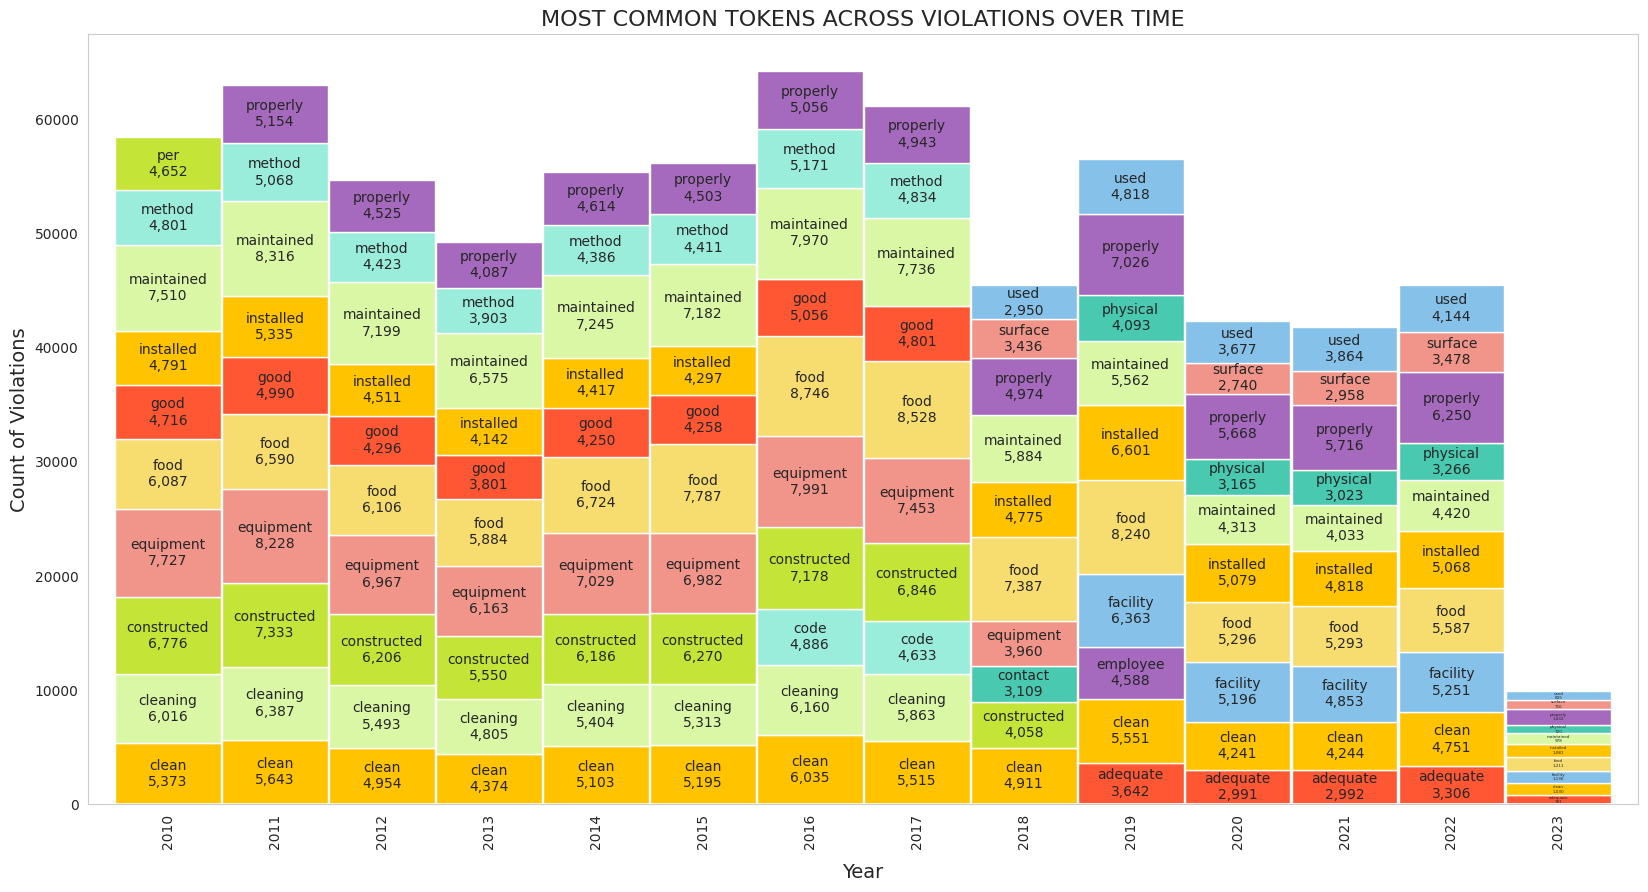

In [20]:
# Use lemmetizer as it was the most effective
r_desc_data = reasons.explode('Tokens_description')
r_desc_data = r_desc_data[['Inspection Date', 'Tokens_description']]

r_desc_data['Tokens_description_modified'] = r_desc_data['Tokens_description'].apply(lambda x: x.lower()) # Convert to lower case
r_desc_data['Tokens_description_modified'] = r_desc_data['Tokens_description_modified'].apply(lambda x: x if len(x) > 1 else np.nan)
r_desc_data['Tokens_description_modified'] = r_desc_data['Tokens_description_modified'].apply(lambda x: x if not str(x).isnumeric() else np.nan)
r_desc_data['Tokens_description_modified'] = r_desc_data['Tokens_description_modified'].apply(lambda x: x if str(x).isalpha() else np.nan)
r_desc_data['Tokens_description_modified'] = r_desc_data['Tokens_description_modified'].apply(lambda x: x if x not in stopwords else np.nan)

r_desc_data = r_desc_data.dropna(subset=['Tokens_description_modified'])
r_desc_data['Tokens_description_modified'] = r_desc_data['Tokens_description_modified'].apply(lambda x: lemmatizer.lemmatize(x))

r_desc_data['Inspection Date'] = pd.to_datetime(r_desc_data['Inspection Date'])
r_desc_data['Year'] = r_desc_data['Inspection Date'].dt.year

r_trends = r_desc_data[['Year', 'Tokens_description_modified']].groupby(by=['Year', 'Tokens_description_modified']).size().reset_index().rename({0:'Count of Violations'}, axis=1)
years = r_trends['Year'].unique()
result = pd.DataFrame()
for year in years:
    tokens_10 = r_trends[r_trends['Year'] == year].sort_values(by=['Count of Violations'], ascending=False).head(10)
    result = pd.concat([result, tokens_10], ignore_index=True)
result = result[['Year', 'Tokens_description_modified', 'Count of Violations']]
# Pivot the data frame to have Tokens_description_modified as columns and year as index
result = result.pivot(index='Year', columns='Tokens_description_modified', values='Count of Violations')

# Plot the stacked bar chart
sns.set_style("whitegrid")
ax = result.plot(kind='bar', stacked=True, figsize=(20,10), color=['#FF5733', '#FFC300', '#DAF7A6', '#9AECDB', '#C4E538', '#48C9B0', '#A569BD', '#F1948A', '#85C1E9', '#F7DC6F'], width=0.99)
ax.grid(False)
plt.title("MOST COMMON TOKENS ACROSS VIOLATIONS OVER TIME", fontsize=16)
plt.xlabel("Year", fontsize=14, labelpad=10)
plt.ylabel("Count of Violations", fontsize=14)
ax.get_legend().remove()

for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    # Skip the columns with no values
    if (height > 0) & (height < 1500):
        ax.text(x+width/2, 
                y+height/2, 
                f'{result.columns[i//len(result.index)]}\n{int(height):,}', 
                horizontalalignment='center', 
                verticalalignment='center', fontsize=3)
    elif height > 1300:
        ax.text(x+width/2, 
                y+height/2, 
                f'{result.columns[i//len(result.index)]}\n{int(height):,}', 
                horizontalalignment='center', 
                verticalalignment='center')
plt.show()

It can be seen that many words are commonly used across the years like 'food', 'maintained', 'clean', 'equipment', etc, which makes sense for food inspections data across the years.
As 2023 is stil ongoing, the count for them are very low and difficult to annotate compared to the other years.